# Question 5

This script designs a Blackman-windowed differentiator filter and explores some of its properties.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [3]:
# Define filter specifications

N_TAPS = 25         # number of filter taps
F_SAMP = 50         # sampling frequency, kHz
F_BAND = [0, 20]    # operating frequency range, kHz

In [4]:
def plot_impz(coeffs, fname=None):
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout()
    plt.stem(coeffs)
    # Axis labels
    ax.set_ylabel("Response")
    # Save or just short
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def plot_freqz(w, h, fname=None):
    """Plot frequency response and overlay filter requirements."""
    fig, axs = plt.subplots(2, sharex=True, figsize=(6, 4))
    fig.tight_layout()
    sns.lineplot(x=w, y=dB(np.abs(h)), ax=axs[0])
    sns.lineplot(x=w, y=np.angle(h), ax=axs[1])
    # Axis labels
    axs[0].set_ylabel("Gain (dB)")
    axs[1].set_xlabel("Frequency (kHz)")
    axs[1].set_ylabel("Phase (rad)")
    # Save or just show
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

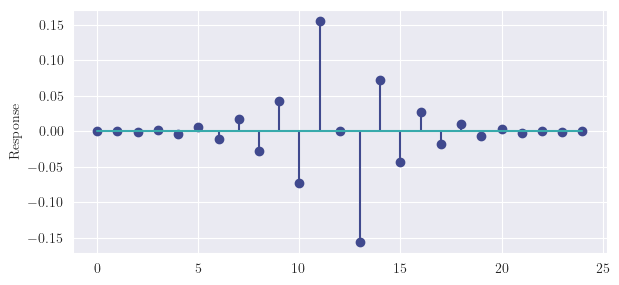

C:\Users\deren\AppData\Local\Temp\ipykernel_19828\2723376721.py:13: RuntimeWarning: divide by zero encountered in log10
  dB = lambda x: 20 * np.log10(x)


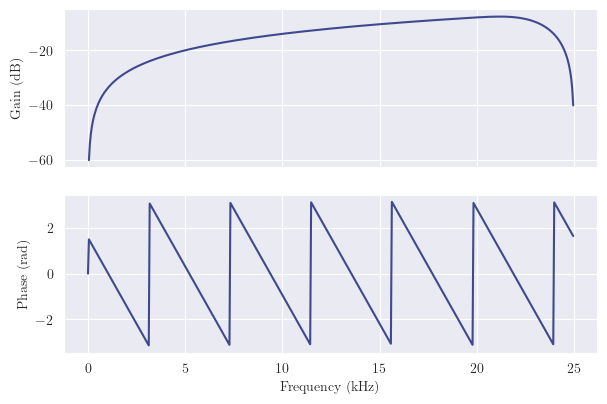

In [5]:
import scipy.signal as signal

# Define differentiator filter
taps = signal.remez(N_TAPS, F_BAND, [1], type="differentiator", fs=F_SAMP)
plot_impz(taps)
f, H = signal.freqz(taps, [1], fs=F_SAMP)
plot_freqz(f, H)

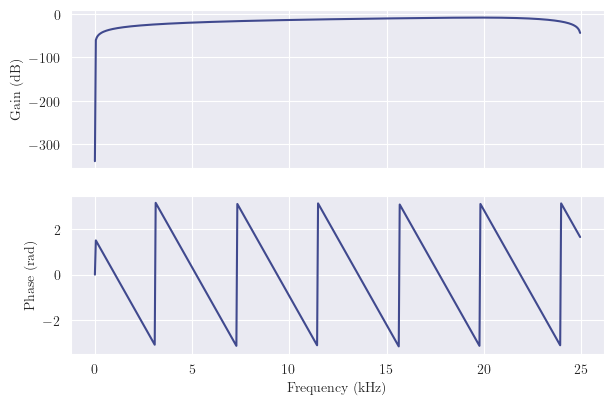

In [6]:
from scipy.fft import fft, ifft
from scipy.signal.windows import blackman

# Apply Blackman window
H_blackman = fft(taps * blackman(N_TAPS), n=1024)[:512]
plot_freqz(f, H_blackman)

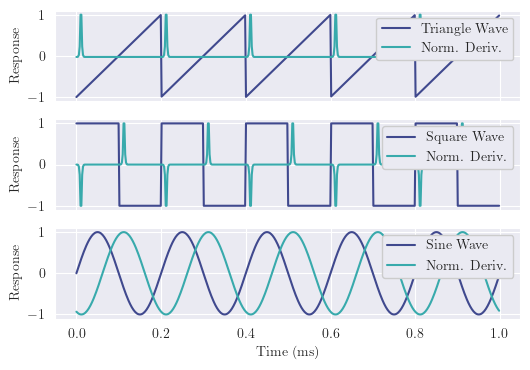

In [18]:
# Generate sample "continuous" functions to test the differentiator filter
t = np.linspace(0, 1, 512, endpoint=False)
t_tri = signal.sawtooth(2 * np.pi * 5 * t)
t_sqr = signal.square(2 * np.pi * 5 * t)
t_sin = np.sin(2 * np.pi * 5 * t)

# Apply the differentiator filter
filt_tri = ifft(fft(t_tri) * H_blackman)
filt_sqr = ifft(fft(t_sqr) * H_blackman)
filt_sin = ifft(fft(t_sin) * H_blackman)

# Plot unfiltered and filtered comparison
normalise = lambda arr: arr.real / max(np.abs(arr.real))
_, axs = plt.subplots(3, sharex=True, figsize=(6, 4))
axs[0].plot(t, t_tri, label="Triangle Wave")
axs[0].plot(t, normalise(filt_tri), label="Norm. Deriv.")
axs[1].plot(t, t_sqr, label="Square Wave")
axs[1].plot(t, normalise(filt_sqr), label="Norm. Deriv.")
axs[2].plot(t, t_sin, label="Sine Wave")
axs[2].plot(t, normalise(filt_sin), label="Norm. Deriv.")
# Axis labels
axs[2].set_xlabel("Time (ms)")
axs[0].set_ylabel("Response")
axs[1].set_ylabel("Response")
axs[2].set_ylabel("Response")
axs[0].legend(loc="upper right", framealpha=1)
axs[1].legend(loc="upper right", framealpha=1)
axs[2].legend(loc="upper right", framealpha=1)
plt.show()